# Market clearing with non-merchant storage

In [1]:
# Import packages (runs on Julia 1.6.1)
using JuMP, GLPK
using CSV, DataFrames
using Plots
using DataStructures

## Input data

In [2]:
# Input number of days, number of hours per day
nb_d = 2
t_per_d = 1
nb_t_tot = nb_d * t_per_d

# Input number of generators and loads
nb_g = 2
nb_l = 1

# Storage data
S = 2.5 # Storage capacity
E_0 = 0; # Initial state of energy
S_df = CSV.read("data_stg.csv", DataFrame) # Final state of energy (optionnal)

2×2 DataFrame
 Row │ time   soe_end 
     │ Int64  Int64   
─────┼────────────────
   1 │     1        2
   2 │     2        2

In [3]:
# Generators
G_df = CSV.read("data_gen.csv", DataFrame) # Full dataframe

4×4 DataFrame
 Row │ time   gen    max    cost  
     │ Int64  Int64  Int64  Int64 
─────┼────────────────────────────
   1 │     1      1      2      5
   2 │     1      2      2     10
   3 │     2      1      2      2
   4 │     2      2      2      9

In [4]:
# Loads
L_df = CSV.read("data_load.csv", DataFrame) # Full dataframe

2×4 DataFrame
 Row │ time   load   max    utility 
     │ Int64  Int64  Int64  Int64   
─────┼──────────────────────────────
   1 │     1      1      0       12
   2 │     2      1      3       12

In [5]:
g_df = groupby(G_df, [:time, :gen]); # Group by time and generator
l_df = groupby(L_df, [:time, :load]); # Group by time and load

# Sets
G = [i for i in 1:nb_g];
L = [i for i in 1:nb_l];
T_all = ["$i" for i in 1:nb_t_tot];

## Function for the market clearing

In [6]:
function mc_storage(t_start, t_end, final_level, E_init)
    model = Model(GLPK.Optimizer)

    T = [i for i in t_start:t_end]
    
    @variables model begin
         p[g in G, t in T] >= 0
         e[t in T] >= 0
         b[t in T]
         d[l in L, t in T] >= 0
    end
    
    @objective(model, Max,
               sum(l_df[(t,l)][1,"utility"]*d[l,t] for l in L, t in T) - sum(g_df[(t,g)][1,"cost"]*p[g,t] for g in G, t in T))
    @constraints model begin
            PowerBalance[t in T], # Constraint (5b)
                sum(p[g, t] for g in G) - b[t] - sum(d[l, t] for l in L) == 0
            Gen_max[g in G, t in T], # Constraint (5c)
                p[g,t] <= g_df[(t, g)][1,"max"]
            Load_max[l in L, t in T], # Constraint (5d)
                d[l,t] <= l_df[(t, l)][1,"max"]
            Stg_max[t in T], # Constraint (1)
                e[t] <= S
            StorageBalance[t in T[2:end]], # Constraint (2)
                e[t] == e[t-1] + b[t]
            StorageBalance_init, # Constraint (3)
                e[T[1]] == E_init + b[T[1]]
    end

    if final_level != "no"
        @constraint(model, Final_level, e[T[end]] == final_level)
    end

    @time optimize!(model)
    println(raw_status(model))
    
    results = Dict()
    e_val = JuMP.value.(e)
    d_val = JuMP.value.(d)
    p_val = JuMP.value.(p)
    λ_val = JuMP.dual.(PowerBalance)
    #obj = JuMP.objective_value(model)
    
    results["e"] = e_val
    results["d"] = d_val
    results["p"] = p_val
    results["λ"] = λ_val

    profit_stg = []
    for t in T
        profit_stg = append!(profit_stg, - λ_val[t] * JuMP.value.(b)[t])
    end
    results["profit_stg"] = profit_stg
        
    return results
end ;


## Market clearing, all days together

In [7]:
t_start = 1
t_end = nb_t_tot
E_init = E_0
final_level = "no";

In [8]:
# Run the optimization
results = mc_storage(t_start, t_end, final_level, E_init);    

 15.705742 seconds (14.89 M allocations: 887.554 MiB, 5.01% gc time, 1.64% compilation time)
Solution is optimal


In [9]:
# Display table with the results
results_df = DataFrame()
results_df.e = results["e"]
for l in L
    results_df.d = results["d"][l,:]
    rename!(results_df, :d => "d$l")
end
for g in G
    results_df.p = results["p"][g,:]
    rename!(results_df, :p => "p$g")
end
results_df.λ = results["λ"]
results_df.profit = results["profit_stg"]

print("Total profit for the storage system: ",sum(results["profit_stg"]))
results_df

Total profit for the storage system: 0.0

2×6 DataFrame
 Row │ e        d1       p1       p2       λ        profit 
     │ Float64  Float64  Float64  Float64  Float64  Any    
─────┼─────────────────────────────────────────────────────
   1 │     1.0      0.0      1.0      0.0      5.0  -5.0
   2 │     0.0      3.0      2.0      0.0      5.0  5.0

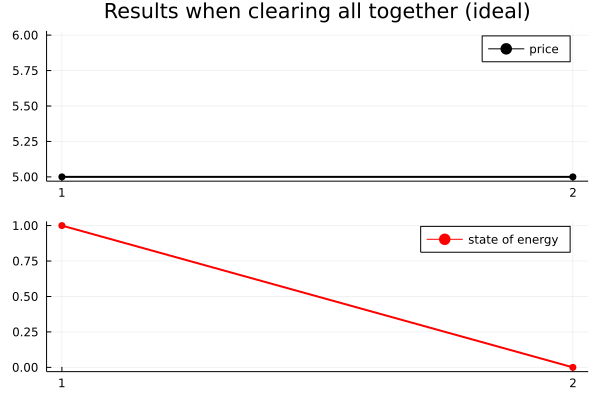

In [10]:
# Plot market price and state of energy vs t
p_price = plot(T_all, results_df[!,"λ"].data, label="price", color=:black, lw = 2, markershape=:circle, markerstrokewidth=0, title = "Results when clearing all together (ideal)")
p_soe = plot(T_all, results_df[!,"e"].data, label="state of energy", color=:red, lw = 2, markershape=:circle, markerstrokewidth=0)
plot(p_price, p_soe, layout = (2, 1))

## Market clearing, day by day

In [11]:
# Final level
print("Final state of energy at the end of one day: \n\n")
print("Write 'no' to not include the constraint, \n\n")
print("Write 'ideal' to use the optimal value, \n\n")
print("Write 'user value' to use predifined values in the csv file. \n\n")
print("Press 'Enter'. \n\n")
final_level_d = readline();
print("\n\n")
print("FINAL STATE OF ENERGY AT THE END OF THE HORIZON: \n\n")
print("Write 'no' to not include the constraint, \n\n")
print("Write 'ideal' to use the optimal value, \n\n")
print("Write 'user value' to use predifined values in the csv file. \n\n")
print("Press 'Enter'. \n\n")
final_level = readline();

Final state of energy at the end of one day: 

Write 'no' to not include the constraint, 

Write 'ideal' to use the optimal value, 

Write 'user value' to use predifined values in the csv file. 

Press 'Enter'. 

stdin> ideal


FINAL STATE OF ENERGY AT THE END OF THE HORIZON: 

Write 'no' to not include the constraint, 

Write 'ideal' to use the optimal value, 

Write 'user value' to use predifined values in the csv file. 

Press 'Enter'. 

stdin> no


In [12]:
# Prepare results
Dict_d = Dict()
Dict_p = Dict()
for l in L
    Dict_d["d$l"] = []
end
for g in G
    Dict_p["p$g"] = []
end
results_separate = Dict("e"=>[],"d"=> Dict_d,"p"=> Dict_p,"λ"=>[],"profit_stg"=>[]);

t_start = 1

# Clear the market for each day in the horizon
for d in 1:nb_d
    global results_separate, E_init, t_start
    if d < nb_d
        if final_level_d == "ideal"
            final_level_d = results["e"][d*t_per_d]
        elseif final_level_d != "no"
            final_level_d = S_df[d*t_per_d,"soe_end"]
        end
        t_end = t_start + t_per_d - 1
        T = [i for i in t_start:t_end]
        results_d = mc_storage(t_start, t_end, final_level_d, E_init)
        t_start += t_per_d
        
        # Update initial level
        E_init = results_d["e"][t_per_d]
    else
        if final_level == "ideal"
            final_level = results["e"][d*t_per_d]
        elseif final_level != "no"
            final_level = S_df[d*t_per_d,"soe_end"]
        end
        t_end = t_start + t_per_d - 1
        T = [i for i in t_start:t_end]
        results_d = mc_storage(t_start, t_end, final_level, E_init)
    end
    # Update results
    results_separate["e"] = append!(results_separate["e"],results_d["e"].data)
    for l in L
        res_d = []
        for t in T
            res_d = append!(res_d, results_d["d"][l,t])
        end
        results_separate["d"]["d$l"] = append!(results_separate["d"]["d$l"],res_d)
    end 
    for g in G
        res_p = []
        for t in T
            res_p = append!(res_p, results_d["p"][g,t])
        end
        results_separate["p"]["p$g"] = append!(results_separate["p"]["p$g"],res_p)
    end 
    results_separate["λ"] = append!(results_separate["λ"],results_d["λ"].data)
    results_separate["profit_stg"] = append!(results_separate["profit_stg"],results_d["profit_stg"])
end

  0.000415 seconds (768 allocations: 58.727 KiB)
Solution is optimal
  0.000299 seconds (758 allocations: 58.055 KiB)
Solution is optimal


In [13]:
# Display table with the results
res_separate_df = DataFrame()
res_separate_df.e = results_separate["e"]
for l in L
    res_separate_df.d = results_separate["d"]["d$l"]
    rename!(res_separate_df, :d => "d$l")
end
for g in G
    res_separate_df.p = results_separate["p"]["p$g"]
    rename!(res_separate_df, :p => "p$g")
end
res_separate_df.λ = results_separate["λ"]
res_separate_df.profit = results_separate["profit_stg"]

print("Total profit for the storage system: ",sum(results_separate["profit_stg"]))
res_separate_df

Total profit for the storage system: 4.0

2×6 DataFrame
 Row │ e    d1   p1   p2   λ    profit 
     │ Any  Any  Any  Any  Any  Any    
─────┼─────────────────────────────────
   1 │ 1.0  0.0  1.0  0.0  5.0  -5.0
   2 │ 0.0  3.0  2.0  0.0  9.0  9.0

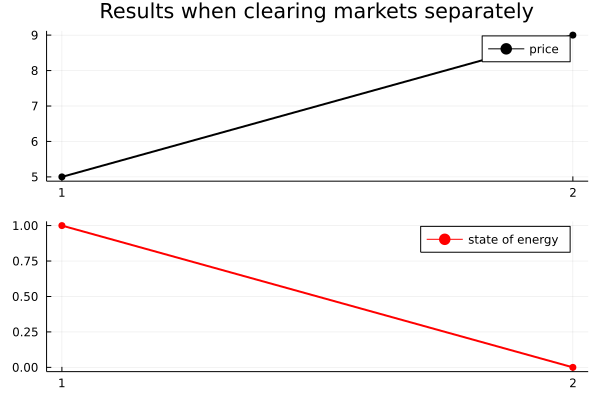

In [14]:
# Plot market price and state of energy vs t
p_price_sep = plot(T_all, res_separate_df[!,"λ"], label="price", color=:black, lw = 2, markershape=:circle, markerstrokewidth=0, title = "Results when clearing markets separately")
p_soe_sep = plot(T_all, res_separate_df[!,"e"], label="state of energy", color=:red, lw = 2, markershape=:circle, markerstrokewidth=0)
plot(p_price_sep, p_soe_sep, layout = (2, 1))